In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [54]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [55]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      84


# Create datasets

## Position index

In [56]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


## data_et

In [57]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

## data_trial

In [58]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [59]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [98]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Enough trials?

In [61]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
46     125         15.0
56    2002        112.0
59    2011         32.0


## Followed instructions? 

In [62]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
5,12,5b8969006651ea000118e42e,1.0,0.0
29,48,5fa1192cf99e161a5cfad1cd,1.0,0.0
51,9,5fea6632bf9ae4a79153efdf,1.0,0.0
72,1003,0,1.0,0.0
74,1008,Ka61Kl61,1.0,0.0
81,2002,Tim2,0.0,0.0
82,2008,Studie1970,0.0,1.0


# Cleaning

## data_subject variables

In [63]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [64]:
cleanSubjects = data_subject.loc[
        (data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])) &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ].unique()
cleanSubjects

array([   1,  103,   11,  126,  128,   13,  130,  131,   19,   24,   25,
         28,   30,   32,   36,   37,    4,   41,   42,   43,   45,   47,
          5,   58,   59,    6,   63,   66,   67,    7,   70,   74,   80,
         81,   85,   91,   92,   93,   94,   96,   97, 1000, 1011, 1021,
       2012, 2013, 2009], dtype=int64)

In [65]:
def cleanTrialData(data):
    print('raw data: ' + str(len(data)))
    data = data.loc[
        data['run_id'].isin(cleanSubjects), 
        :] \
    .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_trial')
data_trial = cleanTrialData(data_trial)
print('\n data_trial_fix')
data_trial_fix = cleanTrialData(data_trial_fix)

data_trial
raw data: 30362
cleaned data: 24234

 data_trial_fix
raw data: 1044
cleaned data: 837


In [66]:
def cleanETData(data, cleanSubjects):
    print('raw data: ' + str(len(data)))
    data = data.loc[
        (data['run_id'].isin(cleanSubjects)), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_et')
data_et = cleanETData(data_et, cleanSubjects)
print('\n data_et_fix')
data_et_fix = cleanETData(data_et_fix, cleanSubjects)

data_et
raw data: 618566
cleaned data: 544508

 data_et_fix
raw data: 65042
cleaned data: 58147


# Offset

## Calculate on gaze point-level

In [67]:
data_trial.loc[
    data_trial['trial_type'].isin(['eyetracking-fix-object']), 
    ['trial_index', 'window_width']]

,trial_index,window_width
104,105.0,1920.0
105,106.0,1920.0
107,108.0,1920.0
108,109.0,1920.0
110,111.0,1920.0
...,...,...
23959,243.0,1920.0
23962,246.0,1920.0
23965,249.0,1920.0
23968,252.0,1920.0


In [68]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [69]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et_fix['offset_px'].describe()

count    58147.000000
mean       207.835831
std        189.575353
min          0.908491
25%         89.091868
50%        152.449107
75%        264.523840
max       2340.081519
Name: offset_px, dtype: float64

## Plot: gaze shift within a trial

In [70]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [71]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [72]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

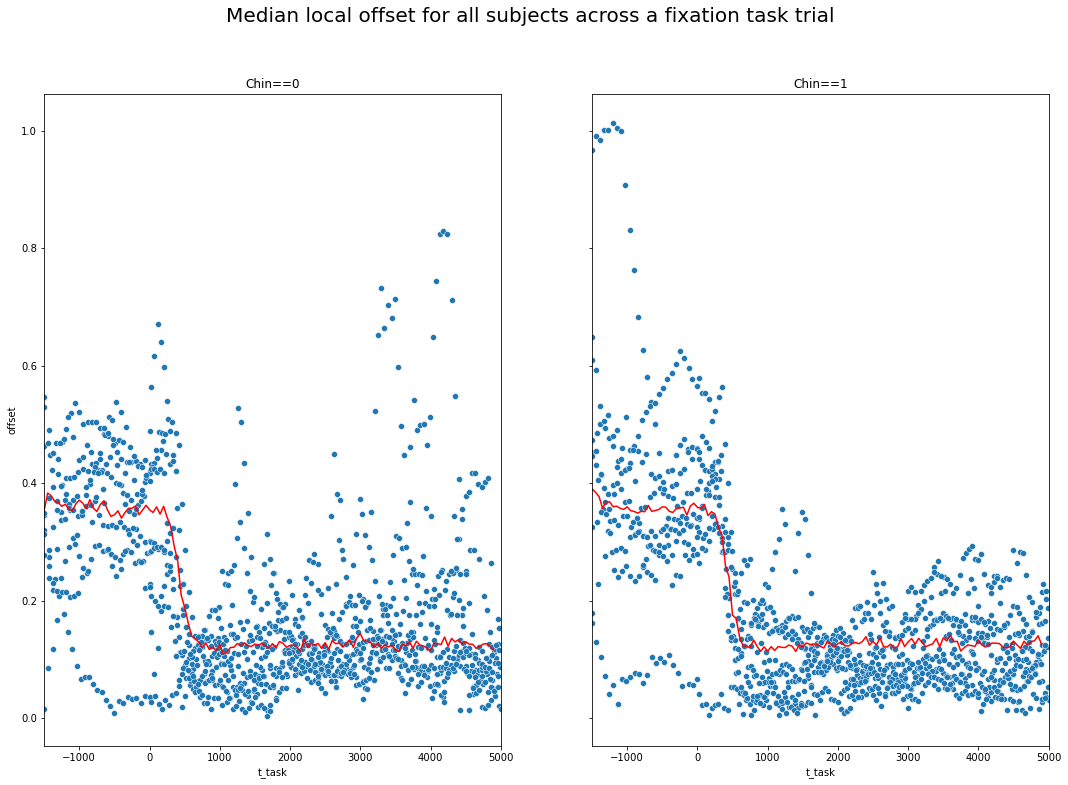

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [74]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')

## Aggregate on subject-level 

In [75]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [76]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,47.000000,46.000000,47.000000,27.000000,18.000000
mean,0.205215,0.190380,0.205446,0.189913,0.194914
std,0.163047,0.141355,0.164243,0.153353,0.092959
min,0.074473,0.069502,0.058736,0.077386,0.074473
25%,0.106993,0.096723,0.110637,0.106156,0.115464
50%,0.160506,0.148895,0.152613,0.143812,0.185468
75%,0.232671,0.223869,0.256177,0.214136,0.254645
max,0.876760,0.802738,0.876760,0.803767,0.410388


In [77]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,47.000000,46.000000,47.000000,27.000000,18.000000
mean,248.895365,228.293300,248.006977,218.142706,247.091797
std,209.058876,167.631555,210.361736,162.970415,132.680201
min,83.776446,60.291561,67.162307,83.776446,84.165071
25%,125.337948,120.342524,129.331858,116.511419,156.547985
50%,204.546806,177.226795,193.530066,170.762958,232.056540
75%,282.897878,283.302117,288.552052,249.273149,297.215793
max,1238.344526,848.289765,1238.344526,847.848319,632.730659


## Grand mean offset

In [113]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-113-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,837.000000,837.000000,837.000000,837.000000
mean,0.500898,803.124313,0.495788,452.210064
std,0.243033,423.748825,0.208850,211.130389
min,-0.698092,-1072.269613,-0.134632,-128.842889
25%,0.309411,515.679725,0.344346,305.225675
50%,0.515563,777.832059,0.509904,440.475857
75%,0.707801,1064.827586,0.652206,591.669806
max,1.218096,2282.275511,0.993750,1126.277549


In [115]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    837.000000
mean       0.180212
std        0.179641
min        0.003546
25%        0.071101
50%        0.125814
75%        0.220212
max        1.285896
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [78]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-78-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,5.814700e+04,5.814700e+04
mean,9.450001e-03,1.084924e+04
std,3.151916e-02,3.800674e+04
min,8.822143e-10,2.051945e-03
25%,9.403697e-04,1.036365e+03
50%,2.789889e-03,3.135455e+03
75%,7.446074e-03,8.488400e+03
max,1.279031e+00,2.024417e+06


## Standard deviation of gaze points on trial-level

In [79]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    837.000000
mean       0.088295
std        0.066099
min        0.000341
25%        0.051707
50%        0.070164
75%        0.100069
max        0.599281
Name: precision, dtype: float64


In pixel

In [80]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    837.000000
mean      96.136380
std       76.075031
min        0.563800
25%       55.684546
50%       73.578111
75%      107.741545
max      702.798557
Name: precision_px, dtype: float64


Any missing values?

In [81]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision


## Aggregate on subject-level 

In [89]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,47.000000,46.000000,47.000000,27.000000,18.000000
mean,0.090668,0.089189,0.087419,0.080242,0.094800
std,0.056816,0.054815,0.057419,0.047054,0.047754
min,0.003469,0.004836,0.002101,0.045034,0.003469
25%,0.059799,0.063880,0.057190,0.055751,0.069191
50%,0.077988,0.077679,0.073472,0.068877,0.087387
75%,0.093893,0.097039,0.091560,0.088407,0.112066
max,0.311413,0.397298,0.311413,0.297975,0.215294


In pixel

In [90]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,47.000000,46.000000,47.000000,27.000000,18.000000
mean,99.237916,97.151001,95.143346,88.267673,99.971201
std,67.176131,63.914959,64.952455,53.727585,52.040777
min,5.245142,6.813137,3.677147,48.540134,5.245142
25%,63.462113,67.580829,58.580129,60.893646,70.778197
50%,78.840480,78.457396,80.963437,75.611353,87.398776
75%,106.523965,103.116344,103.586654,98.804469,123.056491
max,387.680822,446.535285,387.680822,325.185417,202.872690


# Main effect: chin-rest

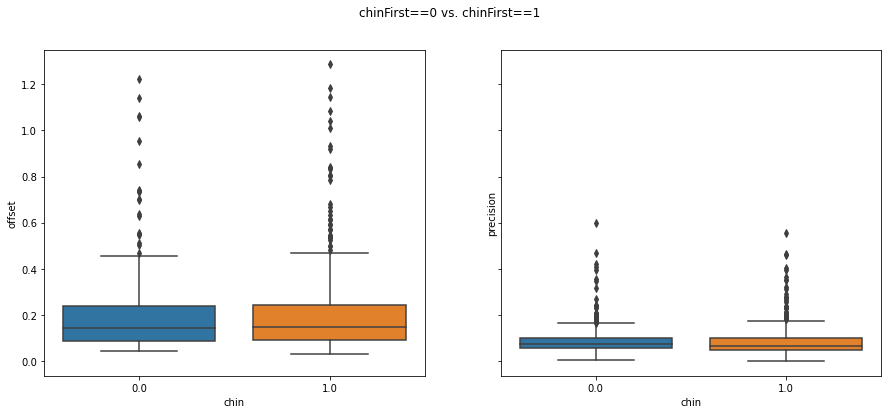

In [91]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [92]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.190380,0.019981
1,offset_chin_1,0.205446,0.026976
2,precision_chin_0,0.089189,0.003005
3,precision_chin_1,0.087419,0.003297


In [93]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-0.03857746920153028, pvalue=0.9693979060967043)

## Compare across chinFirst condition

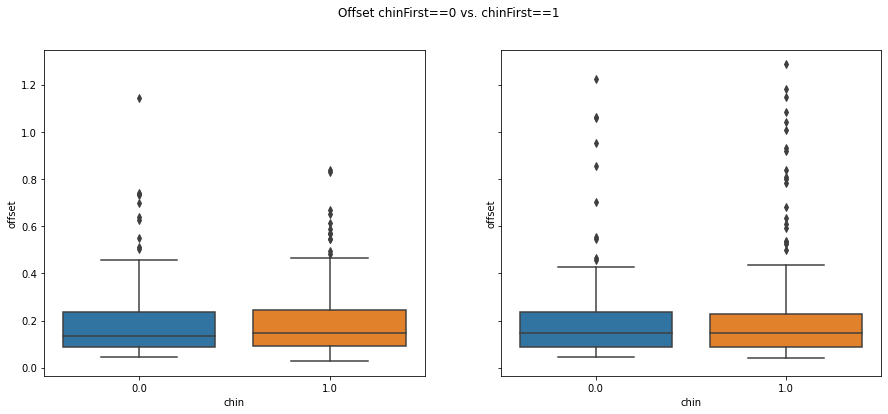

In [94]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

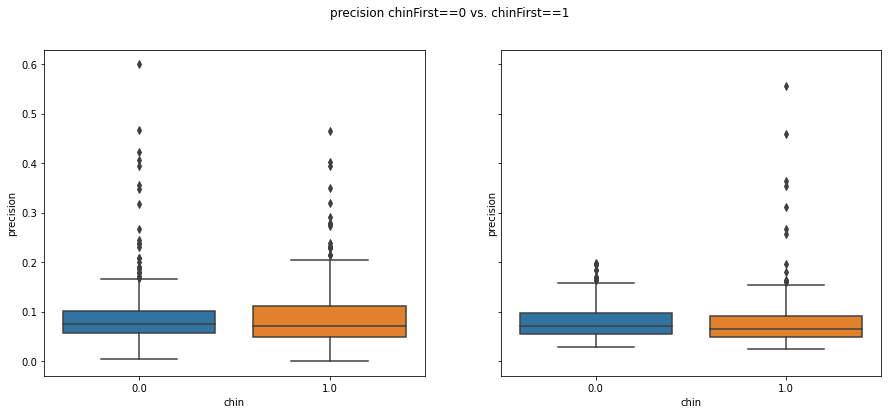

In [95]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

## Compare across fixation dot positions

In [96]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.190380
offset_chin_1           0.205446
offset_var_chin_0       0.026298
offset_var_chin_1       0.036035
precision_chin_0        0.089189
precision_chin_1        0.087419
precision_var_chin_0    0.003923
precision_var_chin_1    0.004838
dtype: float64


<ipython-input-96-15d38b239ff3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
<ipython-input-96-15d38b239ff3>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.212681,0.206952,0.019771,0.023893,0.108535,0.097390,0.007779,0.004641
1,1,0.186429,0.188880,0.016925,0.016654,0.088216,0.084560,0.003806,0.002932
2,2,0.237345,0.198759,0.044362,0.027080,0.102584,0.097364,0.002775,0.003456
3,3,0.180230,0.190445,0.017416,0.024278,0.083238,0.090344,0.003145,0.005619
4,4,0.145351,0.149788,0.016337,0.016073,0.076035,0.079430,0.003320,0.006920
5,5,0.165599,0.212195,0.025494,0.052521,0.086170,0.080188,0.002584,0.002465
6,6,0.215679,0.257955,0.028061,0.043950,0.093786,0.088554,0.004368,0.005785
7,7,0.163416,0.211253,0.027833,0.055529,0.077045,0.083791,0.002911,0.005921
8,8,0.206689,0.232788,0.040487,0.064336,0.087096,0.085149,0.004623,0.005802


# Main effect: Visual Aid

## Compare on subject-level

In [ ]:
for col in ['glasses', 'sight']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

In [ ]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 1, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
data_subject['glasses_binary'].unique()

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

## Fixation dot positions

In [ ]:
if 'glasses_binary' in data_trial_fix.columns: 
    data_trial_fix = data_trial_fix.drop(columns=['glasses_binary'])
data_trial_fix = data_trial_fix.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary', 'sight']],
    on='run_id',
    how='left'
)
grouped_var = data_trial_fix.groupby(['positionIndex', 'glasses_binary']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'glasses_binary']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'glasses_binary'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'glasses_binary', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_glasses_0', 1.0: 'offset_glasses_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'glasses_binary', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_glasses_0', 1.0: 'offset_var_glasses_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'glasses_binary', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_glasses_0', 1.0: 'precision_glasses_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'glasses_binary', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_glasses_0', 1.0: 'precision_var_glasses_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

# Gaze predictions

## For each position

In [ ]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix['x']
y = data_et_fix['y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Calibration: data quality development

In [ ]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial.loc[data_trial['trial_type']=='eyetracking-calibration', :]

## offset

In [ ]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Precision

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

In [ ]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## categorical confounders

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

In [ ]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)

# Correlation Plot

In [ ]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

In [ ]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [ ]:
data_plot[correlation_columns].rcorr()

In [ ]:
data_plot[correlation_columns].rcorr(upper='n')

# MLA Model

In [ ]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

# Export

In [ ]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [ ]:
print('Success! Script ran through')